# IMDB Sentiment Analysis with BiLSTM + Attention (PyTorch & TorchText)

#### This notebook demonstrates a complete deep learning workflow for sentiment analysis on the IMDB movie reviews dataset using a custom BiLSTM with Attention model implemented in PyTorch. It covers data loading, cleaning, tokenization, vocabulary building, encoding, and efficient batching with TorchText. The notebook includes model definition, training with validation, learning rate scheduling, and evaluation with metrics and confusion matrix visualization. Misclassified examples are analyzed to help understand model limitations and guide further improvements.

## Check device CPU/GPU

In [ ]:
# Check if CUDA (GPU) is available and set device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Install Required Packages

In [ ]:
# Install PyTorch and TorchText (run once per environment)
!pip install -U torch==2.3.1+cu121 torchtext==0.18.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/

## Fix Torchmetrics Installation


In [ ]:
# Uninstall broken torchmetrics and install compatible version
!pip uninstall -y torchmetrics
!pip install -U --no-cache-dir torchmetrics==1.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 35.3 MB/s eta 0:00:00


## Import Libraries


In [ ]:
# Import all required libraries for data processing, modeling, and evaluation
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import time
import copy
import matplotlib.pyplot as plt
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from torchmetrics.classification import MulticlassAccuracy, BinaryF1Score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

## Load Dataset

In [ ]:
# Load the IMDB Sentiment dataset and convert to pandas DataFrames
ds = load_dataset("Kwaai/IMDB_Sentiment")

df_train = ds["train"].to_pandas()[["text","label"]]
df_test = ds["test"].to_pandas()[["text","label"]]

print("Train shape:", df_train.shape, "| Test shape:", df_test.shape)
df_train.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train shape: (25000, 2) | Test shape: (25000, 2)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


## Clean Data and Build Vocabulary


In [ ]:
# Clean text and build vocabulary from training data
def clean(text):
  text = re.sub(r"<br\s*/?>", " ", str(text))
  text = re.sub(r"\s+", " ", text).strip()
  return text.lower()

# Tokenizer
tokenizer = get_tokenizer("basic_english")

def yield_tokens_from_train(df):
  for t in df['text'].tolist():
    yield tokenizer(clean(t))

# Build vocab from train only to avoid leakage
MAX_VOCCAB = 60000
vocab = build_vocab_from_iterator(
    yield_tokens_from_train(df_train),
    max_tokens=MAX_VOCCAB,
    specials=["<pad>","<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]

print("Vocab size:", len(vocab), "| PAD_IDX:", PAD_IDX, "| UNK_IDX:", UNK_IDX)

lengths = [len(tokenizer(clean(t))) for t in df_train["text"].tolist()]
p95 = int(np.percentile(lengths, 95))
print("P95:", p95)



Vocab size: 60000 | PAD_IDX: 0 | UNK_IDX: 1
P95: 692


## Encode and Truncate Reviews


In [ ]:
# Encode reviews as token IDs and truncate/pad to fixed length

MAX_LEN = 500
LEFT = MAX_LEN//2
RIGHT = MAX_LEN - LEFT

def head_tail_truncate(ids, max_len=MAX_LEN):
  if len(ids) > max_len:
    return ids[:LEFT] + ids[-RIGHT:]
  else:
    return ids

def encode_ids(text):
  toks = tokenizer(clean(text))
  ids = [vocab[t] for t in toks]
  true_len = min(len(ids), MAX_LEN)
  ids = head_tail_truncate(ids, MAX_LEN)
  if len(ids)<MAX_LEN:
    ids += [PAD_IDX]*(MAX_LEN-len(ids))
  return torch.tensor(ids, dtype=torch.long), torch.tensor(true_len, dtype=torch.long)


## Prepare Datasets and DataLoaders


In [ ]:
# Split into train and validation and build PyTorch DataLoaders

class SentimentAnalysisDataset(Dataset):
  def __init__(self, df):
    self.textx = df["text"].tolist()
    self.labels = df["label"].astype(int).tolist()
  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
    x_ids, x_len = encode_ids(self.textx[idx])
    y = torch.tensor(self.labels[idx], dtype=torch.long)
    return x_ids, x_len, y

def collect_batch(batch):
  ids = torch.stack([x[0] for x in batch], dim=0) # (B,L)
  lengths = torch.stack([x[1] for x in batch], dim=0) # (B,)
  labels = torch.stack([x[2] for x in batch], dim=0) # (B,)
  return ids, lengths, labels

# make validation split
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train["label"],
    random_state=42
    )

train_ds = SentimentAnalysisDataset(train_df)
val_ds = SentimentAnalysisDataset(val_df)
test_ds = SentimentAnalysisDataset(df_test)

# DataLoaders

BATCH_SIZE = 256

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collect_batch)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collect_batch)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collect_batch)

# quick sanity check
xb, xl, yb = next(iter(train_loader))
print("Batch ids:", xb.shape, "| lengths:", xl.shape, "| labels:", yb.shape)
print("Example length stats — min:", int(xl.min()), "max:", int(xl.max()))

Batch ids: torch.Size([256, 500]) | lengths: torch.Size([256]) | labels: torch.Size([256])
Example length stats — min: 35 max: 500


## Model Definition: BiLSTM + Attention


In [ ]:
# Define BiLSTM + Attention model
class SpatialDropout1D(nn.Module):
    """Drop whole embedding dimensions across all time steps (like Keras SpatialDropout1D)."""
    def __init__(self, p: float = 0.1):
        super().__init__()
        self.p = p
    def forward(self, x):               # x: (B, L, E)
        if not self.training or self.p == 0.0:
            return x
        x = x.permute(0, 2, 1).unsqueeze(3)          # (B, E, L, 1)
        x = F.dropout2d(x, p=self.p, training=True)  # drops entire channels (embed dims)
        return x.squeeze(3).permute(0, 2, 1)         # back to (B, L, E)

class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers, dropout, pad_idx, num_classes):
        super().__init__()

        # Embedding + embedding dropouts
        self.embedding     = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.emb_dropout   = nn.Dropout(p=0.20)           # ↑ from 0.1
        self.spatial_drop  = SpatialDropout1D(p=0.10)     # new: drops whole embed dims

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=0.0 if num_layers == 1 else 0.3,      # recurrent dropout only if >1 layer
            batch_first=True
        )

        # Normalize LSTM outputs before attention (helps stability on long seqs)
        self.ln = nn.LayerNorm(2 * hidden_size)

        # Attention: tanh -> (dropout) -> score -> softmax(masked)
        self.attn_proj  = nn.Linear(2 * hidden_size, 128)
        self.attn_drop  = nn.Dropout(p=0.10)              # new: attention MLP dropout
        self.attn_score = nn.Linear(128, 1, bias=False)

        # Classifier head: MLP (stronger than a single Linear)
        head_hidden = hidden_size                          # 2H -> H -> num_classes
        self.head = nn.Sequential(
            nn.Dropout(p=dropout),                         # keep your global dropout here
            nn.Linear(2 * hidden_size, head_hidden),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(head_hidden, num_classes)
        )

    def forward(self, ids, lengths):
        """
        ids: (B, L) token ids
        lengths: (B,) true lengths
        returns: logits (B, C), attn_weights (B, L)
        """
        # Embedding + drops
        emb = self.embedding(ids)                  # (B, L, E)
        emb = self.emb_dropout(emb)
        emb = self.spatial_drop(emb)

        # Pack -> LSTM -> Unpack
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True, total_length=ids.size(1))  # (B, L, 2H)

        # LayerNorm before attention
        out = self.ln(out)

        # Attention with dropout on projection
        h = torch.tanh(self.attn_proj(out))        # (B, L, 128)
        h = self.attn_drop(h)
        scores = self.attn_score(h).squeeze(-1)    # (B, L)

        # Mask PADs
        L = out.size(1)
        mask = torch.arange(L, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1)  # (B, L)
        scores = scores.masked_fill(~mask, float("-inf"))
        attn = torch.softmax(scores, dim=1)        # (B, L)

        # Weighted sum (context vector)
        ctx = torch.sum(out * attn.unsqueeze(-1), dim=1)  # (B, 2H)

        # Classifier head
        logits = self.head(ctx)                    # (B, num_classes)
        return logits, attn

## Training and Validation Loop


In [ ]:
# Training and validation loop for BiLSTM+Attention model
# Includes early stopping and learning rate scheduling
# Tracks accuracy and F1 score for each epoch
# Saves best model checkpoint
# Returns training history


def train_val_loop(
    model,
    train_loader,
    val_loader,
    device,
    ckpt_path,
    num_epochs=30,
    lr=1e-3,
    weight_decay=0.01,
    clip_norm=1.0
):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=3,
                                  cooldown=1, min_lr=1e-5, verbose=True)
    scaler = GradScaler(enabled=(device.type == "cuda"))

    # Metrics (train & val)
    tr_acc = MulticlassAccuracy(num_classes=2).to(device)
    tr_f1  = BinaryF1Score().to(device)
    va_acc = MulticlassAccuracy(num_classes=2).to(device)
    va_f1  = BinaryF1Score().to(device)

    best_state = None
    best_val_f1 = -1
    wait = 0

    # Histories
    hist = {
        "train_loss": [], "train_acc": [], "train_f1": [],
        "val_loss": [],   "val_acc": [],   "val_f1": []
    }

    start = time.perf_counter()

    for ep in range(1, num_epochs + 1):
        # ----- TRAIN -----
        model.train()
        tr_acc.reset(); tr_f1.reset()
        total_loss, total_count = 0.0, 0

        for ids, lens, ys in train_loader:
            ids, lens, ys = ids.to(device), lens.to(device), ys.to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=(device.type == "cuda")):
                logits, _ = model(ids, lens)        # (B, 2)
                loss = loss_fn(logits, ys)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            scaler.step(optimizer)
            scaler.update()

            bs = ys.size(0)
            total_loss  += loss.item() * bs
            total_count += bs

            preds = torch.argmax(logits, dim=1)               # 0/1
            probs_pos = torch.softmax(logits, dim=1)[:, 1]    # P(class=1)
            tr_acc.update(preds, ys)
            tr_f1.update(probs_pos, ys)

        train_loss = total_loss / max(1, total_count)
        train_acc  = tr_acc.compute().item()
        train_f1   = tr_f1.compute().item()

        # ----- VALIDATE -----
        model.eval()
        va_acc.reset(); va_f1.reset()
        val_loss_sum, val_count = 0.0, 0

        with torch.no_grad():
            for ids, lens, ys in val_loader:
                ids, lens, ys = ids.to(device), lens.to(device), ys.to(device)
                logits, _ = model(ids, lens)
                vloss = loss_fn(logits, ys)

                bs = ys.size(0)
                val_loss_sum += vloss.item() * bs
                val_count    += bs

                preds = torch.argmax(logits, dim=1)
                probs_pos = torch.softmax(logits, dim=1)[:, 1]
                va_acc.update(preds, ys)
                va_f1.update(probs_pos, ys)

        val_loss = val_loss_sum / max(1, val_count)
        val_acc  = va_acc.compute().item()
        val_f1   = va_f1.compute().item()

        # Log
        print(f"Epoch {ep:02d} | "
              f"train: loss {train_loss:.4f}, acc {train_acc*100:.2f}%, f1 {train_f1:.4f} | "
              f"val: loss {val_loss:.4f}, acc {val_acc*100:.2f}%, f1 {val_f1:.4f} | "
              f"lr {optimizer.param_groups[0]['lr']:.2e}")

        # Scheduler on validation loss
        scheduler.step(val_loss)

        # saving model with best accuracy
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            if ckpt_path:
                torch.save(best_state, ckpt_path)
                print(f"  ↳ Saved best to {ckpt_path} (val f1 {best_val_f1:.4f})")

        # Save histories
        hist["train_loss"].append(train_loss)
        hist["train_acc"].append(train_acc)
        hist["train_f1"].append(train_f1)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)
        hist["val_f1"].append(val_f1)

    elapsed = (time.perf_counter() - start) / 60.0
    print(f"Done in {elapsed:.2f} min.")

    return hist


## Testing and Error Analysis


In [ ]:
import itertools
# Test loop: loads best model, evaluates on test set, plots confusion matrix
# Prints targeted misclassified examples (false positives and false negatives)

def test_loop(model_ctor, ckpt_path, test_loader, device,
              num_classes=2, plot_confusion=True, normalize_cm=True, class_names=None, id2word=None):

    # --- build model and load weights ---
    model = model_ctor().to(device)
    state = torch.load(ckpt_path, map_location=device)
    state_dict = state.get("model_state", state) if isinstance(state, dict) else state
    model.load_state_dict(state_dict)
    model.eval()

    # --- run inference ---
    all_preds, all_labels, all_inputs = [], [], []
    with torch.no_grad():
        for ids, lens, ys in test_loader:
            ids, lens, ys = ids.to(device), lens.to(device), ys.to(device)
            logits, _ = model(ids, lens)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ys.cpu().numpy())
            all_inputs.extend(ids.cpu().numpy())

    # --- metrics (macro) ---
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )
    print(f"Test Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | "
          f"Recall: {rec*100:.2f}% | F1: {f1*100:.2f}%")

    # --- confusion matrix ---
    if plot_confusion:
        labels = list(range(num_classes))
        cm = confusion_matrix(all_labels, all_preds, labels=labels,
                              normalize="true" if normalize_cm else None)
        if normalize_cm:
            cm = cm * 100.0  # to %
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation="nearest")
        title = "Confusion Matrix (% by true class)" if normalize_cm else "Confusion Matrix (counts)"
        plt.title(title)
        plt.xlabel("Predicted"); plt.ylabel("True")
        cbar_label = "% within true class" if normalize_cm else "count"
        plt.colorbar(label=cbar_label)
        ticks = np.arange(num_classes)
        tick_labels = class_names if (class_names and len(class_names)==num_classes) else ticks
        plt.xticks(ticks, tick_labels, rotation=45, ha="right"); plt.yticks(ticks, tick_labels)

        # annotate cells
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            val = cm[i, j]
            show = (val >= 1.0) if normalize_cm else (val > 0)
            if show:
                txt = f"{val:.0f}%" if normalize_cm else str(int(val))
                plt.text(j, i, txt, ha="center", va="center",
                         color="white" if val > (50 if normalize_cm else cm.max()/2) else "black",
                         fontsize=9)
        plt.tight_layout()
        plt.savefig("confusion_matrix.png", dpi=150)
        plt.show()

       # --- show targeted misclassified examples ---
    print("\n--- Misclassified: Negative → Positive (False Positives) ---")
    count = 0
    for x, y, p in zip(all_inputs, all_labels, all_preds):
        if y == 0 and p == 1:  # true Neg, predicted Pos
            if id2word:
                tokens = [id2word.get(i, "<unk>") for i in x if i not in [0,1,2]]
                text = " ".join(tokens)
            else:
                text = str(x)
            print(f"True: {class_names[y] if class_names else y} | "
                  f"Pred: {class_names[p] if class_names else p} | Input: {text}")
            count += 1
            if count >= 10:
                break

    print("\n--- Misclassified: Positive → Negative (False Negatives) ---")
    count = 0
    for x, y, p in zip(all_inputs, all_labels, all_preds):
        if y == 1 and p == 0:  # true Pos, predicted Neg
            if id2word:
                tokens = [id2word.get(i, "<unk>") for i in x if i not in [0,1,2]]
                text = " ".join(tokens)
            else:
                text = str(x)
            print(f"True: {class_names[y] if class_names else y} | "
                  f"Pred: {class_names[p] if class_names else p} | Input: {text}")
            count += 1
            if count >= 10:
                break


## Model Instantiation, Training, and Evaluation


Model params: 6.30M
Epoch 01 | train: loss 0.6322, acc 64.14%, f1 0.6507 | val: loss 0.5131, acc 76.50%, f1 0.7606 | lr 1.00e-03
  ↳ Saved best to bilstm.pth (val f1 0.7606)
Epoch 02 | train: loss 0.4987, acc 78.16%, f1 0.7825 | val: loss 0.4123, acc 83.88%, f1 0.8403 | lr 1.00e-03
  ↳ Saved best to bilstm.pth (val f1 0.8403)
Epoch 03 | train: loss 0.4228, acc 83.43%, f1 0.8346 | val: loss 0.3823, acc 85.90%, f1 0.8609 | lr 1.00e-03
  ↳ Saved best to bilstm.pth (val f1 0.8609)
Epoch 04 | train: loss 0.3789, acc 86.42%, f1 0.8635 | val: loss 0.4439, acc 83.00%, f1 0.8489 | lr 1.00e-03
Epoch 05 | train: loss 0.3458, acc 88.53%, f1 0.8850 | val: loss 0.3525, acc 87.86%, f1 0.8737 | lr 1.00e-03
  ↳ Saved best to bilstm.pth (val f1 0.8737)
Epoch 06 | train: loss 0.3207, acc 89.90%, f1 0.8988 | val: loss 0.3419, acc 89.30%, f1 0.8933 | lr 1.00e-03
  ↳ Saved best to bilstm.pth (val f1 0.8933)
Epoch 07 | train: loss 0.2994, acc 91.17%, f1 0.9119 | val: loss 0.3675, acc 88.62%, f1 0.8797 | lr 1

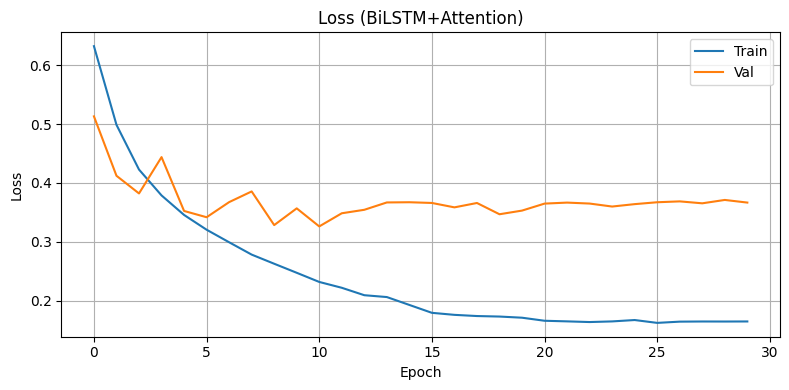

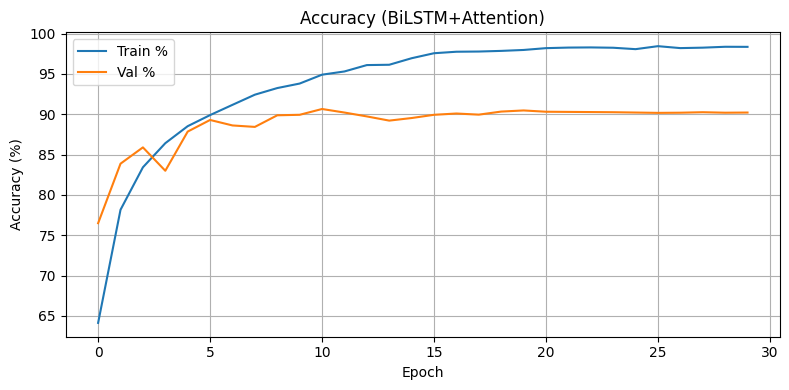

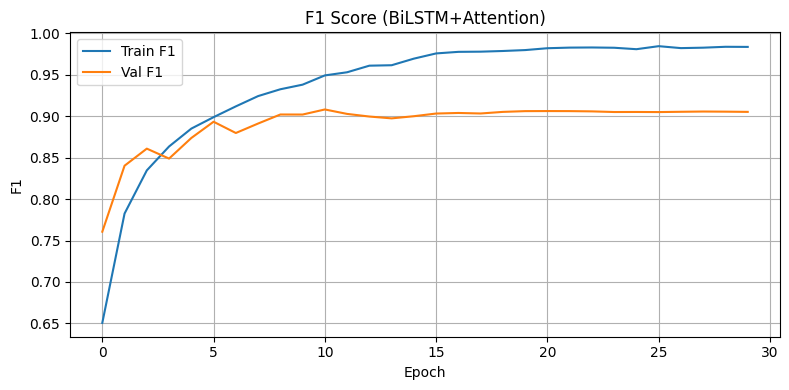

Test Accuracy: 89.67% | Precision: 89.68% | Recall: 89.67% | F1: 89.67%


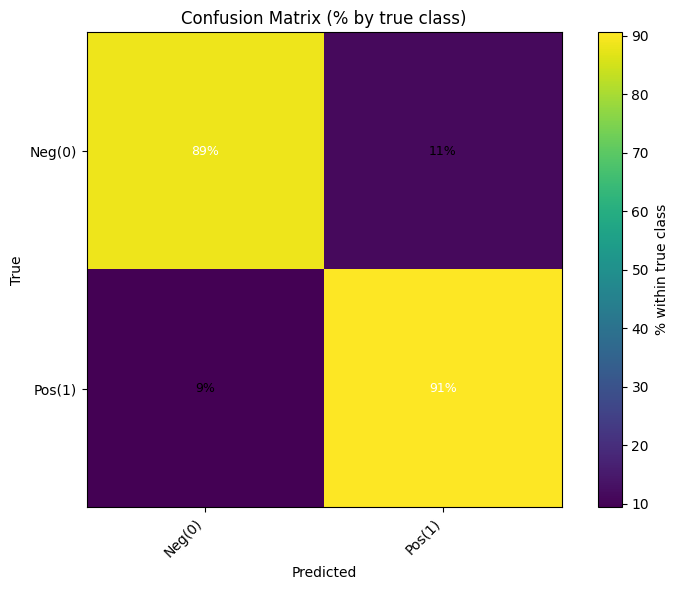


--- Misclassified: Negative → Positive (False Positives) ---
True: Neg(0) | Pred: Pos(1) | Input: first off let me say , if you haven ' t enjoyed a van damme movie since bloodsport , you probably will not like this movie . most of these movies may not have best plots or best actors but i enjoy these kinds of movies for what they are . this movie is much better than any of movies other action guys ( segal and dolph ) have thought about putting out past few years . van damme is good in movie , movie is only worth watching to van damme fans . it is not as good as wake of death ( which i highly recommend to anyone of likes van damme ) or in hell but , in my opinion it ' s worth watching . it has same type of feel to it as nowhere to run . good fun stuff !
True: Neg(0) | Pred: Pos(1) | Input: isaac florentine has made some of best western martial arts action movies ever produced . in particular us seals 2 , cold harvest , special forces and undisputed 2 are all action classics . you can te

In [ ]:

# Instantiate BiLSTM+Attention, train, plot metrics, and test
NUM_CLASSES = 2
bilstm_ckpt = "bilstm.pth"

# instantiate
def make_bilstm():
    return BiLSTMAttention(
        vocab_size=len(vocab),
        embed_dim=100,
        hidden_size=128,
        num_layers=1,
        dropout=0.6,
        pad_idx=PAD_IDX,
        num_classes=NUM_CLASSES
    )

bilstm_model = make_bilstm()
param_count = sum(p.numel() for p in bilstm_model.parameters())
print(f"Model params: {param_count/1e6:.2f}M")

hist = train_val_loop(
    model=bilstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    ckpt_path=bilstm_ckpt,
    num_epochs=30,
    lr=1e-3,
    weight_decay=0.01,
    clip_norm=1.0
)

# Best epoch by lowest val loss
best_epoch = 1 + int(np.argmin(hist["val_loss"]))
print(f"Best epoch: {best_epoch} (val loss = {min(hist['val_loss']):.4f})")

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(hist["train_loss"], label="Train")
plt.plot(hist["val_loss"],   label="Val")
plt.title("Loss (BiLSTM+Attention)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot([a*100 for a in hist["train_acc"]], label="Train %")
plt.plot([a*100 for a in hist["val_acc"]],   label="Val %")
plt.title("Accuracy (BiLSTM+Attention)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["train_f1"], label="Train F1")
plt.plot(hist["val_f1"],   label="Val F1")
plt.title("F1 Score (BiLSTM+Attention)")
plt.xlabel("Epoch"); plt.ylabel("F1")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

try:
    id2word = {i: tok for i, tok in enumerate(vocab.get_itos())}
except Exception:
    id2word = None


# Test and error analysis
test_loop(
    model_ctor=make_bilstm,
    ckpt_path=bilstm_ckpt,
    test_loader=test_loader,
    device=device,
    num_classes=NUM_CLASSES,
    plot_confusion=True,
    normalize_cm=True,
    class_names=["Neg(0)", "Pos(1)"],
    id2word=id2word
)